# Exercise 7

# Part 1 - DT

## Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
# read the data and set "datetime" as the index
bikes = pd.read_csv('../dataset/bikeshare.csv', index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
total         10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(9)
memory usage: 1.1 MB


#### DATA:
Cada observación corresponde al total de bicicletas alquiladas por hora diferenciando entre días festivos y días entre semana con la variable workingday

In [6]:
bikes.head()

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  total  hour  
datetime                                                                   
2011-01-01 00:00:00        81        0.0       3          13     16     0  
2011-01-01 01:00:00        80        0.0       8          32     40     1  
2011-01-01 02:00:00        80        0.0       5          27     32     2  
2011-01-01 03:00:00        75        0.0       3          10     13     3  
2011-01-01 04:00:00        75        0.0       0           1      1     4

- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [7]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [8]:
# mean rentals for each value of "hour"
bikes.groupby(['hour']).total.mean().sort_values(ascending=False)

hour
17    468.765351
18    430.859649
8     362.769231
16    316.372807
19    315.278509
13    257.787281
12    256.508772
15    254.298246
14    243.442982
20    228.517544
9     221.780220
7     213.116484
11    210.674725
10    175.092308
21    173.370614
22    133.576754
23     89.508772
6      76.259341
0      55.138462
1      33.859031
2      22.899554
5      19.767699
3      11.757506
4       6.407240
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

### Respuesta:
Se observa de la siguiente gráfica que a partir de la hora 5 el total de alquileres de bicicleta aumentan y decrece en las 10 horas para repuntar en 15 horas. Mientras que en las últimas horas del día hay un decenso progresivo. 

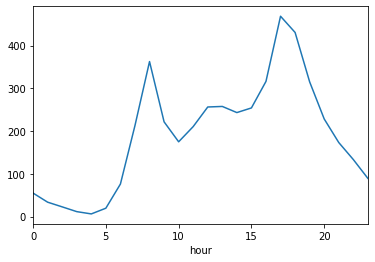

In [9]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot();

Plot for workingday == 0 and workingday == 1

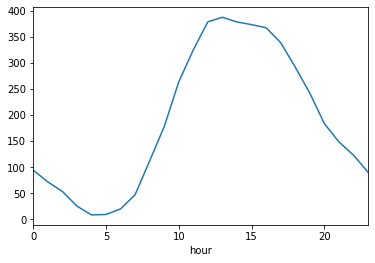

In [10]:
# hourly rental trend for "workingday=0"
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

In [11]:
# hourly rental trend for "workingday=1"
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

In [12]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()

# Write about your findings:
## Respuesta 7.2

Como se observa en las gráficas anteriores,  se requieren dos líneas de regresión para modelar bien los datos, separando la datos por workingday=0 y workingday = 1, pues el comportamiento de los datos de renta (total) son sustanciamente difentes entre las dos curvas, especialmente entre las 9 y 17 horas. 

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

### Respuesta

El modelo de regresión ajustado es total = 10.49*hour + 4.07*workingday

Los valores de los coeficientes nos dicen que:

*si la horas aumentan en una unidad entonces el total de bicicletas rentadas aumentará en promedio en 10.5  con la variable workingday constante. 

*El parámetro b2 (workingday) es el cambio en el promedio del total de rentas debido a un cambio del tipo de día de trabajo del tipo Workingday=0 al tipo workingday = 1. De manera que, al cambiar del workingday=0 a workingday = 1, el número total de rentas aumenta en 4.07 rentas. 

-cuando workingday = 0, entonces y=10.49*hour
-cuando workingday = 1, entonces y=10.49*hour + 4.07


El gráfico de los residuales muestra que no se cumple el supuesto de homocedasticidad porque los errores presentan un patrón en su comportamiento ("comportamiento sistemático" y no aleatorio)

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 


In [14]:
Y = bikes.total
X = bikes[['hour','workingday']]

In [15]:
reg = LinearRegression() 
reg.fit(X, Y) 
# regression coefficients
print('Coefficients: \n', reg.coef_) 


Coefficients: 
 [10.49206282  4.07248627]


In [16]:
## plotting residual errors 
plt.style.use('fivethirtyeight') ;
plt.scatter(reg.predict(X), reg.predict(X) - Y, 
            color = "blue", s = 10, label = 'data') ;
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 
plt.legend(loc = 'upper right') 
plt.title("Residual errors") 

Text(0.5, 1.0, 'Residual errors')

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

## Respuesta 7.4

Seleccionamos las variables para hacer el árbol

In [17]:
df = bikes[['total','hour','workingday']].reset_index(drop=True)
df.head()

total  hour  workingday
0     16     0           0
1     40     1           0
2     32     2           0
3     13     3           0
4      1     4           0

In [18]:
# encode categorical variables as integers
df['workingday'] = pd.factorize(df.workingday)[0]
df['hour'] = pd.factorize(df.hour)[0]

Decidimos categorizar la variable total usando su promedio (antes y después de la media)

In [19]:
# define X and y
X = df[['hour','workingday']]
y = (df.total > 145).astype(int) # es una variable binaria tomando el dato del medio
#y=df.total
y.head()

0    0
1    0
2    0
3    0
4    0
Name: total, dtype: int32

### Construyendo el ábol de decisión a mano

In [20]:
#construimos variables para inicalizar la construcción del árbol manualmente

max_depth = None
num_pct = 10 # percentiles o puntos de corte
max_features = None  #son las variables
min_gain=0.001 # esta variable la dejamos en 1%

In [21]:
j = 0
print(X.columns[j]) #  la variable j y se parte en 10 percentiles. En este caso la variable es horas

hour


En esta lista de splits se muestran los puntos en los cuales se está partiendo la variable que queremos utilizar para para construir el árbol de decisión.

In [22]:
# Split the variable in num_ctp points (num_ctp son los percentiles o puntos de corte)
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits =np.unique(splits) # los splits son puntos de corte ... en este caso se obtienen 10 (usamos unique para no tener números repetidos)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

Ahora queremos evaluar que tan buena es cada partición. Para esto escogemos la partición 5. 

In [23]:
k= 5

In [24]:
#Ahora se parte la base de datos en dos, en este caso que sea menor a 9. Queremos calcular que tan buena es a partición,
#separando los buenos de los malos, para esto se construye y_left y y_right

filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]  # los valores de la variable respuesta está tomando valore de 0 y 1
y_r = y.loc[~filter_l]

### Se define la función del gini. 
Se calcula este estadístico para para saber que tan buena es la partición. 
La impureza de Gini de un nodo es la probabilidad de que una muestra elegida al azar en un nodo se etiquete incorrectamente.


In [25]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [26]:
gini_l = gini(y_l) 
gini_l # gini del lado izquierdo

0.4099189270957957

In [27]:
gini_r = gini(y_r)
gini_r #gini del lado derecho

0.4131944444444444

### una sola función que recoge todo lo que ya se había hecho

In [28]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0] 
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [29]:
gini_impurity(X.iloc[:, j], y, splits[k])
# El mejor gini que se obtiene por haber usado esa partición es 

0.08843322131216141

### Se prueba con todos los cortes y todos las variables
(Se parte el arbol una sola vez)
Ahora tenemos que escoger para todas la variables y para todas las posibles particiones, la mejor partición y eso lo hacemos con la siguiente función: 

In [30]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:   #se itera por todas la variables y por eso num_pc es un input
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits : se calcula el giny impurity para todas las particiones posibles
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain] # se almacena la mejor partición
    
    return best_split

In [31]:
j, split, gain = best_split(X, y, 5)
print('La mejor variable es : ',  X.columns[0])
print('El mejor split : ',  split)

# la mejor forma de partir este grupo de observaciones en dos es utilizando la variable j y dividiendola en el best_split

La mejor variable es :  hour
El mejor split :  8.0


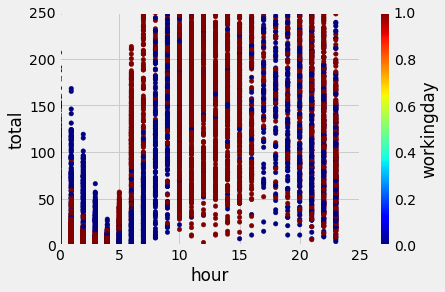

In [32]:
# Lo anterior implica que lo mejor es coger la variable hora y dividir las observaciones en hour = best_split, 
#quedando unas observaciones al lado izquierdo y las otras al lado derecho
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# scatter plot of Years versus Hits colored by Salary
bikes.plot(kind='scatter', x='hour', y='total', c='workingday', colormap='jet', xlim=(0, 25), ylim=(0, 250));

Ahora calculamos a ver como se distribuye la variable objetivo y

In [33]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [34]:
y.shape[0], y_l.shape[0], y_r.shape[0] # total de observaciones, observaciones del lado izquierdo, observaciones del lado derecho

(10886, 3594, 7292)

In [35]:
print('Porcentaje de observaciones 1 y 0, en la base completa : ',  y.mean()*100, 100-y.mean()*100)
print('Antes de las 8 horas, la probabilidad de tener alquileres altos es de: ',  y_l.mean())
print('Después de las 8 horas, la probabilidad de tener alquileres altos es de: : ',  y_r.mean())

Porcentaje de observaciones 1 y 0, en la base completa :  49.91732500459305 50.08267499540695
Antes de las 8 horas, la probabilidad de tener alquileres altos es de:  0.09404563160823595
Después de las 8 horas, la probabilidad de tener alquileres altos es de: :  0.6988480526604498


### construcción del árbol con una función recursiva

In [36]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [37]:
tree= tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10) # Con max_depth fijamos 6 nodos 
tree

{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 0.06425451863089747,
  'sl': {'y_pred': 0,
   'y_prob': 0.026106335561922954,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 0.0027878761479700337,
   'sl': {'y_pred': 0,
    'y_prob': 0.010796723752792257,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 0.0008089140964271449},
   'sr': {'y_pred': 0,
    'y_prob': 0.11816192560175055,
    'level': 3,
    'split': [1, 1.0],
    'n_samples': 455,
    'gain': 0.012693028347051799,
    'sl': {'y_pred': 0,
     'y_prob': 0.006802721088435374,
     'level': 4,
     'split': -1,
     'n_samples': 145,
     'gain': 0},
    'sr': {'y_pred': 0,
     'y_prob': 0.17307692307692307,
     'level': 4,
     'split': -1,
     'n_samples': 310,
     'gain': 0}}},
  'sr'

### Predicción: 
La función tree_predict hace la predicción para todas las observaciones

In [38]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted 

In [39]:
#devuelve para cada una de las observaciones la predicción que puede ser 0, 1

tree_predict(X, tree)

array([0., 0., 0., ..., 1., 0., 0.])

# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

#### Respuesta:

Estimamos un árbol de decisión usando Sklearn para diferentes valores del max_depth, para determinar cuál es el que nos permite
obtener el mayor accuracy. 
De acuerdo con la gráfica siguiente, el mejor accuracy se obtiene con un max_depth de 5  y despues de 6 no hay ganancia 
en el accuracy. 
También, podemos confirmar que la variable más importante para la construcción del árbol es la variable horas.

In [40]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

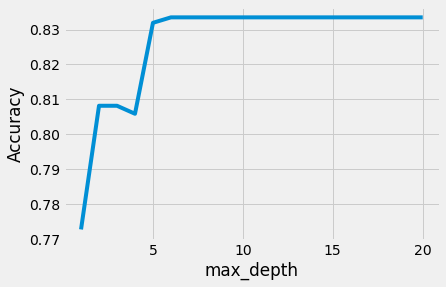

In [41]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy');

In [42]:
# Muestra el mejor accuracy y su max_depth correspondiente
sorted(zip(accuracy_scores, max_depth_range))

[(0.772683689728071, 1),
 (0.8058463752473466, 4),
 (0.8081430721630275, 2),
 (0.8081430721630275, 3),
 (0.8319267081785326, 5),
 (0.8334927505070823, 6),
 (0.8334927505070823, 7),
 (0.8334927505070823, 8),
 (0.8334927505070823, 9),
 (0.8334927505070823, 10),
 (0.8334927505070823, 11),
 (0.8334927505070823, 12),
 (0.8334927505070823, 13),
 (0.8334927505070823, 14),
 (0.8334927505070823, 15),
 (0.8334927505070823, 16),
 (0.8334927505070823, 17),
 (0.8334927505070823, 18),
 (0.8334927505070823, 19),
 (0.8334927505070823, 20)]

In [43]:
# max_depth=2 was best, so fit a tree using that parameter
clf = DecisionTreeClassifier(max_depth=6, random_state=1)
clf.fit(X, y);

In [44]:
# Muestra la importancia de las variables
pd.DataFrame({'feature':X, 'importance':clf.feature_importances_}).sort_values('importance')

feature  importance
1  (w, o, r, k, i, n, g, d, a, y)    0.037531
0                    (h, o, u, r)    0.962469

# Part 2 - Bagging

## Mashable news stories analysis

Predicting if a news story is going to be popular

In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [46]:
df = pd.read_csv('../dataset/mashable.csv', index_col=0)
df.head()

url  timedelta  \
0  http://mashable.com/2014/12/10/cia-torture-rep...       28.0   
1  http://mashable.com/2013/10/18/bitlock-kicksta...      447.0   
2  http://mashable.com/2013/07/24/google-glass-po...      533.0   
3  http://mashable.com/2013/11/21/these-are-the-m...      413.0   
4  http://mashable.com/2014/02/11/parking-ticket-...      331.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0             9.0             188.0         0.732620               1.0   
1             7.0             297.0         0.653199               1.0   
2            11.0             181.0         0.660377               1.0   
3            12.0             781.0         0.497409               1.0   
4             8.0             177.0         0.685714               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0.844262        5.0             1.0       1.0  ...   
1                  0.815789        9.0             4.0       1.0  ...   
2                  0.775701        4.0             3.0       1.0  ...   
3                  0.677350       10.0             3.0       1.0  ...   
4                  0.830357        3.0             2.0       1.0  ...   

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.200000                   0.80              -0.487500   
1               0.160000                   0.50              -0.135340   
2               0.136364                   1.00               0.000000   
3               0.100000                   1.00              -0.195701   
4               0.100000                   0.55              -0.175000   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                  -0.60              -0.250000                 0.9   
1                  -0.40              -0.050000                 0.1   
2                   0.00               0.000000                 0.3   
3                  -0.40              -0.071429                 0.0   
4                  -0.25              -0.100000                 0.0   

   title_sentiment_polarity  abs_title_subjectivity  \
0                       0.8                     0.4   
1                      -0.1                     0.4   
2                       1.0                     0.2   
3                       0.0                     0.5   
4                       0.0                     0.5   

   abs_title_sentiment_polarity  Popular  
0                           0.8        1  
1                           0.1        0  
2                           1.0        0  
3                           0.0        0  
4                           0.0        0  

[5 rows x 61 columns]

In [47]:
df.shape

(6000, 61)

In [48]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [49]:
y.mean() # se observa que la data está balanceada en total de unos y ceros

0.5

In [50]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [51]:
y_test.head()

1483    0
2185    1
2520    0
3721    1
3727    0
Name: Popular, dtype: int64

# Exercise 7.6

Estimate a Decision Tree Classifier and a Logistic Regression

Evaluate using the following metrics:
* Accuracy
* F1-Score

#### Respuesta: 
El mejor ajuste se obtiene con el clasificador de decision porque tiene accuracy y f1 score más altos. 

In [52]:
#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


In [53]:
#Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=12)
a=clf.fit(X_train, y_train)
y_pred_clf = a.predict(X_test)
print('f1 score: ', metrics.f1_score(y_pred_clf, y_test))
print('accuracy: ', metrics.accuracy_score(y_pred_clf, y_test))
print(classification_report(y_test, y_pred_clf))

f1 score:  0.6633416458852869
accuracy:  0.64
              precision    recall  f1-score   support

           0       0.66      0.58      0.61       744
           1       0.63      0.70      0.66       756

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.64      0.64      1500



In [54]:
lr = LogisticRegression(random_state=0)
b=lr.fit(X_train, y_train)
y_pred_lr = b.predict(X_test)
print('f1 score: ', metrics.f1_score(y_pred_lr, y_test))
print('accuracy: ', metrics.accuracy_score(y_pred_lr, y_test))
print(classification_report(y_test, y_pred_lr))

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1 score:  0.6104529616724739
accuracy:  0.6273333333333333
              precision    recall  f1-score   support

           0       0.61      0.68      0.64       744
           1       0.65      0.58      0.61       756

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0.63      1500
weighted avg       0.63      0.63      0.63      1500



# Exercise 7.7

Estimate 300 bagged samples

Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

In [55]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 300

# create 100  bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size = n_samples, replace=True) for _ in range(1, n_B+1)]


In [56]:
# show the rows for the first decision tree: muestra la primera muestra para el primer modelo
X_train.iloc[samples[0], :]

timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
2239      142.0            11.0             135.0         0.631579   
4838      349.0            10.0            1411.0         0.431259   
1047      731.0            12.0             238.0         0.621277   
373       583.0             8.0             253.0         0.661355   
2595      659.0            15.0             458.0         0.512088   
4767      218.0             8.0            2276.0         0.326174   
213       638.0             9.0               0.0         0.000000   
5203      476.0            12.0             324.0         0.583607   
3571      474.0            13.0             140.0         0.726619   
3493       52.0             9.0            1172.0         0.381647   
1830      679.0            11.0             506.0         0.565844   
3563      268.0             9.0             140.0         0.705426   
4654      606.0            11.0             892.0         0.469595   
4094      507.0            10.0             330.0         0.613982   
4068      140.0            10.0             435.0         0.509434   
347        50.0             9.0             195.0         0.692708   
4993      357.0            13.0             236.0         0.639485   
5364      723.0            11.0             182.0         0.634831   
1047      731.0            12.0             238.0         0.621277   
254        30.0            10.0             431.0         0.521226   
1895      253.0            13.0             640.0         0.516835   
806       202.0             7.0             505.0         0.485772   
1218      199.0            11.0             559.0         0.425047   
5453      436.0            12.0            1082.0         0.396961   
2597      602.0             8.0             132.0         0.769231   
1491       23.0             9.0             676.0         0.512346   
4509      456.0            14.0             697.0         0.459064   
3184      240.0            10.0             983.0         0.412435   
1440       73.0            10.0            1365.0         0.464177   
1444      221.0            14.0             533.0         0.462264   
...         ...             ...               ...              ...   
819       697.0            10.0             129.0         0.689922   
4720      244.0            15.0            1562.0         0.452019   
4451      128.0             9.0            2445.0         0.359027   
3514      358.0            10.0             277.0         0.591241   
4303      466.0            10.0             135.0         0.688889   
3815       79.0             9.0               0.0         0.000000   
2047      424.0            13.0             421.0         0.597468   
5051      588.0             7.0             909.0         0.451111   
3861      510.0            13.0             192.0         0.706806   
2531      391.0            11.0             273.0         0.657895   
3633      120.0            10.0             903.0         0.410106   
379        98.0             9.0               0.0         0.000000   
69        657.0             8.0            1305.0         0.342126   
4746      206.0            13.0             558.0         0.535780   
3760      609.0            10.0             847.0         0.522424   
512       666.0            10.0             407.0         0.575682   
176       569.0             9.0             294.0         0.515901   
1904       62.0            13.0               0.0         0.000000   
1291      535.0             9.0             391.0         0.610825   
3462      720.0            12.0            1215.0         0.410448   
2616      450.0            10.0             294.0         0.637631   
1208      411.0            14.0             422.0         0.532663   
3586      518.0            10.0             701.0         0.544787   
5740       28.0            15.0            1133.0         0.431635   
1962      707.0             6.0             293.0         0.540070   
3212       37.0 

### se construye un modelo para cada muestra

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
import math

models = {0: LogisticRegression(),
          1: DecisionTreeClassifier(max_depth=2, random_state=123),
          2: DecisionTreeClassifier(max_depth=None, random_state=123)}


n_samples = X_train.shape[0]
n_B = 300
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


In [58]:
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [60]:
for i in range(300):
    count = math.floor((i)/100)  
    y = y_train.iloc[samples[i]]
    X = X_train.iloc[samples[i], :]
    modelo = models[count].fit(X, y)
    y_pred[[i]] = modelo.predict(X_test)

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

In [61]:
y_pred.head()

0   1   2   3   4   5   6   7   8   9    ... 290 291 292 293 294 295 296  \
1483   1   1   1   1   1   1   1   1   1   1  ...   1   0   1   1   0   1   1   
2185   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
2520   1   1   1   1   1   1   1   1   1   1  ...   1   0   1   0   1   0   1   
3721   1   1   1   1   1   1   1   1   1   1  ...   1   0   0   1   1   1   0   
3727   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   1   0   0   

     297 298 299  
1483   1   0   0  
2185   1   1   0  
2520   0   1   1  
3721   1   1   1  
3727   0   0   0  

[5 rows x 300 columns]

# Exercise 7.8

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [79]:
y_pred_mayority = (y_pred.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
y_pred_mayority.head()

1483    1
2185    1
2520    1
3721    1
3727    0
dtype: int32

In [109]:
print('Valor para la medida F1 Score para Majority Voting %f' % metrics.f1_score(y_pred_mayority, y_test))

Valor para la medida F1 Score para Majority Voting 0.629986


In [110]:
print('Valor para la medida accuracy para Majority Voting %f' % metrics.accuracy_score(y_pred_mayority, y_test))

Valor para la medida accuracy para Majority Voting 0.641333


# Exercise 7.9

Estimate te probability as %models that predict positive

Modify the probability threshold and select the one that maximizes the F1-Score

In [82]:
from sklearn.metrics import precision_recall_curve
n_estimators = n_B
y_pred_f1 = (y_pred.sum(axis=1)/n_estimators)

In [83]:
y_pred_f1.head()

1483    0.920000
2185    0.876667
2520    0.843333
3721    0.873333
3727    0.066667
dtype: float64

In [84]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_f1)

##### Después de calcular los puntajes de precisión, recuperación y umbral, se obtienen matrices NumPy. Luego se usan las funciones NumPy para encontrar el umbral que maximice la puntuación F1

In [85]:
f1_score = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_score)])
print('Best F1-Score: ', np.max(f1_score))

Best threshold:  0.12666666666666668
Best F1-Score:  0.7118126272912424


# Exercise 7.10

Ensemble using weighted voting using the oob_error (EROR DE MUESTREO)

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [86]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [87]:
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    count = math.floor((i)/100)
    y_pred_ = models[count].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

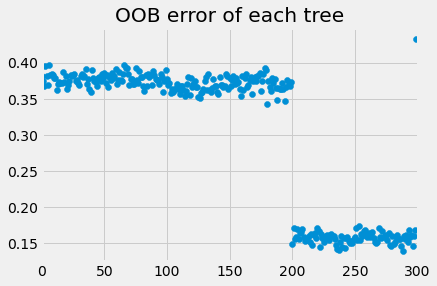

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree');

### Los modelos de Desición Tree sin profundidad son mas precisos

In [89]:
alpha = (1 - errors) / (1 - errors).sum()
weighted_sum_1 = ((y_pred) * alpha).sum(axis=1)
weighted_sum_1.head(8)

1483    0.904644
2185    0.852453
2520    0.810947
3721    0.846725
3727    0.080540
4524    0.512622
234     0.063307
4735    0.163786
dtype: float64

In [97]:
y_pred_weighted = (weighted_sum_1 >= 0.5).astype(np.int)
metrics.f1_score(y_pred_weighted, y_test), metrics.accuracy_score(y_pred_weighted, y_test)

(0.6350515463917525, 0.646)

# Exercise 7.11

Estimate te probability of the weighted voting

Modify the probability threshold and select the one that maximizes the F1-Score

In [90]:
precision, recall, thresholds = precision_recall_curve(y_test, weighted_sum_1);

In [91]:
f1_w_voting = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_w_voting)])
print('Best F1-Score: ', np.max(f1_w_voting))

Best threshold:  0.1479415786408364
Best F1-Score:  0.7121057985757884


# Exercise 7.12

Estimate a logistic regression using as input the estimated classifiers

Modify the probability threshold such that maximizes the F1-Score

#### Respueta:

Se usan los 300 modelos ya entrenados como input de un nuevo modelo, para hacerlo nos basamos en el método de stacking. 

In [103]:
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))
X_train_2.head(5)

0    1    2    3    4    5    6    7    8    9    ...  290  291  292  \
2420  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1225  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
324   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
5863  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
86    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      293  294  295  296  297  298  299  
2420  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1225  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
324   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5863  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
86    NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 300 columns]

In [93]:
for i in range(300):
    count = math.floor((i)/100)  
    y = y_train.iloc[samples[i]]
    X = X_train.iloc[samples[i], :]
    modelo = models[count].fit(X, y)
    y_pred[[i]] = modelo.predict(X_test)
    X_train_2[i] = modelo.predict(X_train)
    

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MaxCalCo\AppData\Local\Continuum\anaconda3\lib\site-package

In [94]:
X_train_2.head()

0    1    2    3    4    5    6    7    8    9    ...  290  291  292  \
2420    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
1225    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
324     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
5863    1    1    0    1    1    1    0    0    0    1  ...    1    1    1   
86      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   

      293  294  295  296  297  298  299  
2420    1    1    1    0    1    1    1  
1225    1    1    0    1    0    1    1  
324     0    0    1    0    0    0    0  
5863    1    1    1    1    1    1    1  
86      1    1    1    1    0    0    1  

[5 rows x 300 columns]

In [95]:
from sklearn.linear_model import LogisticRegressionCV

In [98]:
lr = LogisticRegressionCV(cv = 5 )
lr.fit(X_train_2, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [133]:
y_pred_cl = lr.predict_proba(y_pred)[:,1]
y_pred_cl

array([0.88425952, 0.73305713, 0.55671719, ..., 0.68552228, 0.44535374,
       0.13267775])

In [135]:
y_pred_pro = (weighted_sum_1 >= 0.5).astype(np.int)

In [136]:
metrics.f1_score(y_pred_pro, y_test), metrics.accuracy_score(y_pred_pro, y_test)

(0.6350515463917525, 0.646)

In [137]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_cl);
precision

array([0.50636303, 0.50603217, 0.50637156, ..., 1.        , 1.        ,
       1.        ])

In [138]:
f1_score_cl = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_score_cl)])
print('Best F1-Score: ', np.max(f1_score_cl))

Best threshold:  0.23971433384129281
Best F1-Score:  0.711087975013014
